In [1]:
# To help with reading and manipulation of data
import numpy as np
import pandas as pd
import pprint

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

# to create k folds of data and get cross validation score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# to create pipeline and make_pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# to use standard scaler
from sklearn.preprocessing import StandardScaler

# To impute missing values
from sklearn.impute import SimpleImputer

# To build a Random forest classifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier

# To tune a model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

# To get different performance metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
)

# To undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# To suppress warnings
import warnings

warnings.filterwarnings("ignore")
main_data = pd.read_csv('BankChurners.csv')

default_color_palette  = ["#03A9F4","#7C4DFF", "#FF5252", "#D50000", "#FF6F00", "#0288D1", "#7C4DFF"]
maritalstatus_color_palette = {'Single':'#ff3d00', 'Married':'#00c853', 'Divorced': '#EA112F'}
stats_colors           = {'Mean':'#D50000', 'Mode':'#FF3D00', 'Median':'#2962FF'} # Set standard colors for mean, mode and median to use accross entire notebook.
gender_color_palette   = {"F":"#E91E63", "M":"#42A5F5"} # Gender based colors.

In [2]:
'''
Input:
Pandas DataFrame

Output:
Displays DataFrame structure 
(columns, nulls and non nulls counts and percentage highlighing columns with most number of nulls)

Retunrs:
N/A
'''
def info(dataFrame):
    print(f"{dataFrame.shape[0]} Rows x {dataFrame.shape[1]} Columns")
    nulls_series      = dataFrame.isna().sum()         # Get a series counting number of empty values for each column
    nonnulls_series   = dataFrame.notnull().sum()      # Get a series counting number of non empty valuesfor each column 
    nulls_percentage  = ((nulls_series * 100)/(nulls_series + nonnulls_series)).astype(float)
    column_datatypes  = dataFrame.dtypes               # Get a series containing data types for each column 
    
    series_arr    = [nulls_series, nonnulls_series, nulls_percentage, column_datatypes]
    col_names_arr = ["Nulls", "Non-Nulls","Nulls %", "Type"]
    
    nulls_count_df = pd.concat(
        objs = series_arr,
        axis = 1,
        keys = col_names_arr, 
        sort = True)
    
    cm = sns.light_palette("red", as_cmap=True)
    display(nulls_count_df.style.background_gradient(cmap=cm, subset=pd.IndexSlice[:, ['Nulls %']]).format(formatter={('Nulls %'): "{:.2f}%"})) 
    

'''
Input:
Target type and a list of feature names.

Output:
Convert all features provided in 'column_names' to Target type provided in 'toType'

Returns:
modifies main original data frame and returns nothing.
'''
def ConvertColTo(toType, column_names=np.nan, df = np.nan):
    for col_name in column_names:
        df[col_name] = df[col_name].astype(toType)


'''
Input:
N/A

Output:
Go through each categorial column and print unique values for that column.

Retunrs:
N/A
'''
def CountUniqueValues(col_names):
    for col_name in col_names:
        print(f"======================='{col_name}'==================")
        for unique_col_value in  main_data[col_name].unique().tolist():
            total_count = main_data[col_name].count()
            unique_values_count = main_data[main_data[col_name] == unique_col_value][col_name].count()
            percentage = str(round((unique_values_count/total_count) * 100, 2))
            print(f"{unique_col_value} \t: {unique_values_count} ({percentage}%)")
        print(f"=========================================================\n")

'''
Description:
Given the model the test data y values, displays the confusion matrix for that model.

Input:
model    - The learning model.
y_actual - Y values from test data.
labels   - the labels

Returns:
N/A
'''
def DisplayConfusionMatrix(model, y_actual, labels=[1,0]):
    y_predict             = model.predict(x_test)
    confusion_matrix      = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    
    confusion_matix_df = pd.DataFrame(
        data    = confusion_matrix,
        index   = [i for i in ["Actual No", "Actual Yes"]],
        columns = [i for i in ["Predicted - No", "Predicted - Yes"]])
    
    group_counts     = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
    group_percetages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percetages)]
    labels = np.array(labels).reshape(2, 2)
    plt.figure(figsize= (10,7))
    sns.heatmap(confusion_matix_df, annot=labels,fmt='')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

'''
Description:
Given the model, computes models perfomance on test and training data.
Perf metrics displayed are: Accuracy, Recall, F1 Score, and precision.

Input:
model - The learning model.

Returns:
A dictionary containing models perfomace.
'''
def GetMetricsScore(model):
    
    pred_train      = model.predict(x_train)
    pred_test       = model.predict(x_test)
    
    train_accuracy  = model.score(x_train, y_train)
    test_accuracy   = model.score(x_test, y_test)
    
    train_recall    = metrics.recall_score(y_train, pred_train)
    test_recall     = metrics.recall_score(y_test, pred_test)
    
    train_precision = metrics.precision_score(y_train, pred_train)
    test_precision  = metrics.precision_score(y_test, pred_test)

    f1_score_train  = 2 * ((train_precision * train_recall)/(train_precision + train_recall))
    f1_score_test   = 2 * ((test_precision * test_recall)/(test_precision + test_recall))
    
    return {
        'Accuracy_Test'   : test_accuracy,
        'Accuracy_Train'  : train_accuracy,
        'Recall_Test'     : test_recall,
        'Recall_Train'    : train_recall,
        'Precision_Test'  : test_precision,
        'Precision_Train' : train_precision,
        'F1_Score_Train'  : f1_score_train,
        'F1_Score_Test'   : f1_score_test
    }
        
'''
Description:
Given the model, displays the importance score.

Input:
model - The learning model.

Returns:
N/A
'''
def DisplayImportanceScores(model):
    gini_importances = pd.DataFrame(
        data    = model.feature_importances_, 
        columns = ["Imp"],
        index   = x_train.columns).sort_values(by = "Imp")
    
    print(gini_importances)

'''
Description:
Given the model, displays the importance chart.

Input:
model    - The learning model.

Returns:
N/A
'''
def DisplayImportanceChart(model):
    importances = model.feature_importances_
    indices     = np.argsort(importances)

    plt.figure(figsize=(12, 12))
    plt.title('Feature Importance')
    plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
    plt.yticks(range(len(indices)), [list(X.columns)[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

'''
Description:
Given the decision tree model, displays the decision tree of that model.

Input:
model - The learning model.
size  - Size of the plot

Returns:
N/A
'''
def PlotDecisionTree(model, size= [20, 30]):
    plt.figure(figsize=(size[0],size[1]))
    tree.plot_tree(model, feature_names=feature_names, filled=True, fontsize=9, node_ids=True, class_names=True)
    plt.show()
 
'''
Description:
Given a model, displays the coefient values of that model

Input:
model - The learning model.

Returns:
N/A
'''
def DisplayCoeficients(model):
    coefs = pd.DataFrame(
        np.append(model.coef_, model.intercept_),
        index=x_train.columns.tolist() + ["Intercept"],
        columns=["Coefficients"],
    )

    coefs.sort_values('Coefficients')

### Data Exploration

In [3]:
main_data.head(10)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311
6,810347208,Existing Customer,51,M,4,NaN,Married,$120K +,Gold,46,...,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066
7,818906208,Existing Customer,32,M,0,High School,NaN,$60K - $80K,Silver,27,...,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048
8,710930508,Existing Customer,37,M,3,Uneducated,Single,$60K - $80K,Blue,36,...,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
9,719661558,Existing Customer,48,M,2,Graduate,Single,$80K - $120K,Blue,36,...,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144


In [4]:
TARGET_COLUMN = 'Attrition_Flag'

In [5]:
info(main_data)

10127 Rows x 21 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,10127,0.00%,object
Avg_Open_To_Buy,0,10127,0.00%,float64
Avg_Utilization_Ratio,0,10127,0.00%,float64
CLIENTNUM,0,10127,0.00%,int64
Card_Category,0,10127,0.00%,object
Contacts_Count_12_mon,0,10127,0.00%,int64
Credit_Limit,0,10127,0.00%,float64
Customer_Age,0,10127,0.00%,int64
Dependent_count,0,10127,0.00%,int64
Education_Level,1519,8608,15.00%,object


In [6]:
main_data.drop("CLIENTNUM", axis=1, inplace=True)

### Missing Values Treatment

In [7]:
catgry_col_names = main_data.select_dtypes(include=['object']).columns.tolist()
catgry_col_names.remove(TARGET_COLUMN)

In [8]:
ConvertColTo('category', catgry_col_names, main_data)
info(main_data)

10127 Rows x 20 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,10127,0.00%,object
Avg_Open_To_Buy,0,10127,0.00%,float64
Avg_Utilization_Ratio,0,10127,0.00%,float64
Card_Category,0,10127,0.00%,category
Contacts_Count_12_mon,0,10127,0.00%,int64
Credit_Limit,0,10127,0.00%,float64
Customer_Age,0,10127,0.00%,int64
Dependent_count,0,10127,0.00%,int64
Education_Level,1519,8608,15.00%,category
Gender,0,10127,0.00%,category


In [9]:
catgry_col_names = main_data.select_dtypes(include=['category']).columns.tolist()
CountUniqueValues(catgry_col_names)

======================='Gender'==================
M 	: 4769 (47.09%)
F 	: 5358 (52.91%)

======================='Education_Level'==================
High School 	: 2013 (23.39%)
Graduate 	: 3128 (36.34%)
Uneducated 	: 1487 (17.27%)
nan 	: 0 (0.0%)
College 	: 1013 (11.77%)
Post-Graduate 	: 516 (5.99%)
Doctorate 	: 451 (5.24%)

======================='Marital_Status'==================
Married 	: 4687 (49.98%)
Single 	: 3943 (42.05%)
nan 	: 0 (0.0%)
Divorced 	: 748 (7.98%)

======================='Income_Category'==================
$60K - $80K 	: 1402 (13.84%)
Less than $40K 	: 3561 (35.16%)
$80K - $120K 	: 1535 (15.16%)
$40K - $60K 	: 1790 (17.68%)
$120K + 	: 727 (7.18%)
abc 	: 1112 (10.98%)

======================='Card_Category'==================
Blue 	: 9436 (93.18%)
Gold 	: 116 (1.15%)
Silver 	: 555 (5.48%)
Platinum 	: 20 (0.2%)



In [10]:
main_data['Education_Level'].fillna(main_data['Education_Level'].value_counts().idxmax(), inplace=True)
main_data['Marital_Status'].fillna(main_data['Marital_Status'].value_counts().idxmax(), inplace=True)

In [11]:
info(main_data)

10127 Rows x 20 Columns


,Nulls,Non-Nulls,Nulls %,Type
Attrition_Flag,0,10127,0.00%,object
Avg_Open_To_Buy,0,10127,0.00%,float64
Avg_Utilization_Ratio,0,10127,0.00%,float64
Card_Category,0,10127,0.00%,category
Contacts_Count_12_mon,0,10127,0.00%,int64
Credit_Limit,0,10127,0.00%,float64
Customer_Age,0,10127,0.00%,int64
Dependent_count,0,10127,0.00%,int64
Education_Level,0,10127,0.00%,category
Gender,0,10127,0.00%,category


In [12]:
CountUniqueValues(catgry_col_names)

======================='Gender'==================
M 	: 4769 (47.09%)
F 	: 5358 (52.91%)

======================='Education_Level'==================
High School 	: 2013 (19.88%)
Graduate 	: 4647 (45.89%)
Uneducated 	: 1487 (14.68%)
College 	: 1013 (10.0%)
Post-Graduate 	: 516 (5.1%)
Doctorate 	: 451 (4.45%)

======================='Marital_Status'==================
Married 	: 5436 (53.68%)
Single 	: 3943 (38.94%)
Divorced 	: 748 (7.39%)

======================='Income_Category'==================
$60K - $80K 	: 1402 (13.84%)
Less than $40K 	: 3561 (35.16%)
$80K - $120K 	: 1535 (15.16%)
$40K - $60K 	: 1790 (17.68%)
$120K + 	: 727 (7.18%)
abc 	: 1112 (10.98%)

======================='Card_Category'==================
Blue 	: 9436 (93.18%)
Gold 	: 116 (1.15%)
Silver 	: 555 (5.48%)
Platinum 	: 20 (0.2%)



In [13]:
        
'''
Description:
Displays a grid catplots

Input:
A list of column names
'''
def DisplayCountPlotGrid(col_names, hue_name, color_palette):
    col_index = 0
    for r in range(0, int(len(col_names)), 3):
        fig, axs = plt.subplots(
            nrows=1,                                                                # Number of rows of the grid
            ncols=3,                                                                # Number of columns of the grid.
            figsize=(15,4),
            constrained_layout=True)

        for index in range(0, 3):
            if col_index < int(len(col_names)):
                column_name = col_names[col_index]
                ax = axs.flat[index]
                ax = sns.countplot(
                    data=main_data,
                    x=main_data[column_name],
                    palette=color_palette,
                    hue=hue_name,
                    ax = ax)
                ax.set_xlabel(column_name)                                           
                ax.set_title(column_name + ' and '+ hue_name +' Profile', fontsize=14)
                if int(len(ax.get_xticklabels())) > 14: 
                    ax.set_xticklabels([], rotation=45, ha='right')
                else:
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            col_index += 1
            
'''
Input:
N/A

Output:
Plot box plots in line.

Returns:
N/A
'''     
def PlotLineOfCountPlots(columns, hue_name, palette_name):
    fig, axs = plt.subplots(
        len(columns),
        figsize = (15,10),
        sharex  = False,
        sharey  = False)
    
    fig.subplots_adjust(
        left    = None,
        bottom  = None, 
        right   = None,
        top     = 10,
        wspace  = 10,
        hspace  = None)
    
    for i in range(len(columns)):
        column_name = columns[i]
        sns.countplot(
            data    = main_data, 
            x       = column_name,
            hue     = hue_name,
            palette = palette_name,
            ax      = axs[i])
        
        axs[i].set_xlabel(column_name)                                           
        axs[i].set_title(column_name + ' Profile', fontsize=14)

In [14]:
main_data.select_dtypes(include=['float', 'int64']).columns.tolist()

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [15]:
descrete_data_columns_set       = set(main_data.select_dtypes(include=['float', 'int64']).columns.tolist())
large_descrete_data_columns_set = ['Customer_Age',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Months_on_book',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

large_descrete_data_columns = list(descrete_data_columns_set.difference(large_descrete_data_columns_set))
descrete_data_columns       = list(descrete_data_columns_set)

In [16]:
large_descrete_data_columns

['Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Dependent_count']

In [17]:
descrete_data_columns

['Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Ct',
 'Total_Trans_Amt',
 'Months_on_book',
 'Total_Relationship_Count',
 'Avg_Open_To_Buy',
 'Credit_Limit',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Revolving_Bal',
 'Dependent_count',
 'Customer_Age',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

### Exploring Univariate Analysis based on Gender

In [18]:
catgry_col_names.append(TARGET_COLUMN)
print(catgry_col_names)

['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Attrition_Flag']


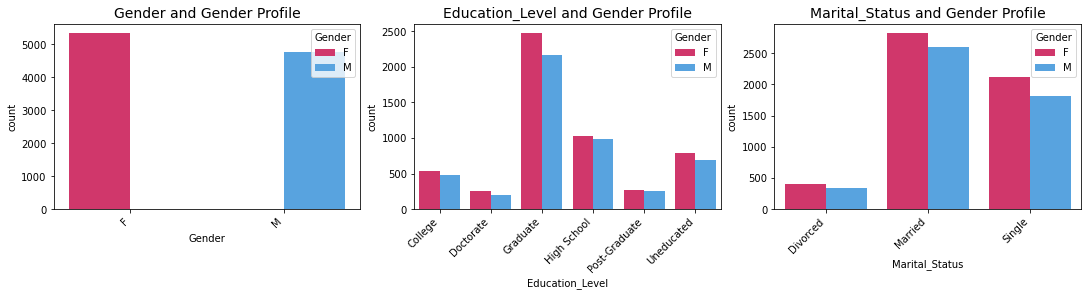

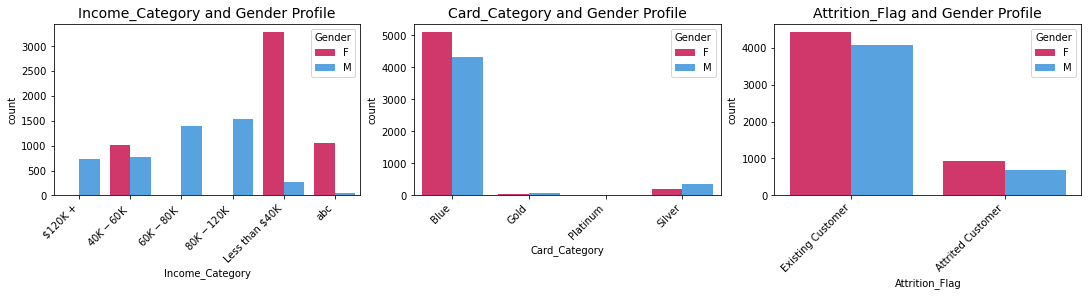

In [19]:
DisplayCountPlotGrid(
    col_names     = catgry_col_names,
    hue_name      = "Gender",
    color_palette = gender_color_palette)

In [ ]:
DisplayCountPlotGrid(
    col_names    = descrete_data_columns,
    hue_name     = "Gender",
    color_palette = gender_color_palette)

In [ ]:
PlotLineOfCountPlots(
    columns      = large_descrete_data_columns,
    hue_name     = "Gender",
    palette_name = gender_color_palette)

### Exploring Univariate Analysis based on  Marital Status

In [ ]:
DisplayCountPlotGrid(
    col_names    = catgry_col_names,
    hue_name     = "Marital_Status",
    color_palette = maritalstatus_color_palette)

In [ ]:
DisplayCountPlotGrid(
    columns       = descrete_data_columns,
    hue_name      = "Marital_Status",
    color_palette = maritalstatus_color_palette)

In [ ]:
PlotLineOfCountPlots(
    col_names    = large_descrete_data_columns,
    hue_name     = "Marital_Status",
    palette_name = maritalstatus_color_palette)

### Feature engineering

In [ ]:
replace_struct = {
    "Card_Category"       : {"Blue": 1, "Silver": 2, "good": 3, "Gold": 4, "Platinum": 5},
    "Income_Category"     : {"abc": -1, "Less than $40K": 1, "$40K - $60K": 2, "$60K - $80K": 3, "$80K - $120K": 4, "$120K +": 5},
    "Education_Level"     : {"Uneducated": 1, "High School": 2, "College": 3, "Graduate": 4, "Post-Graduate":5, "Doctorate": 6},
    "Attrition_Flag"      : {"Existing Customer": 0, "Attrited Customer": 1},
}

main_data = main_data.replace(replace_struct)
main_data.head(10)

In [ ]:
oneHotCols = ["Gender", "Marital_Status"]
main_data = pd.get_dummies(main_data, columns=oneHotCols)
info(main_data)

In [ ]:
main_data[TARGET_COLUMN] = pd.to_numeric(main_data[TARGET_COLUMN], downcast="integer")

In [ ]:
info(main_data)

### Corrolation and Skewness

In [ ]:
fig, ax = plt.subplots(figsize=(18,18)) 
sns.heatmap(data=main_data.corr().sort_values(by=[TARGET_COLUMN]), annot=True, linewidths=.5, ax=ax)
plt.show()

In [ ]:
'''
Input:
Axis, column name/x-axis, hue name

Output:
Displays a count plot.

Retunrs:
N/A
''' 
def HistBoxplot(box_chart_ax, hist_chart_ax, x_axis):
    sns.boxplot(
        data=main_data,
        x=main_data[x_axis],
        showmeans=True,
        ax=box_chart_ax)
    
    sns.histplot(
        data=main_data,
        x=main_data[x_axis],
        kde=True,
        ax=hist_chart_ax)
    
    hist_chart_ax.axvline(main_data[x_axis].mean(),                 # Get the mean of the values in the given column and draw a vertical line that cuts the chart on the mean value 
               color=stats_colors['Mean'],                                  # Use on of the colors predefined on this notebook
               label='Mean',                                                # Set the label to be diplayed on the legend
               linestyle="dashed");                                         # Make the line have dashes
    
    hist_chart_ax.axvline(main_data[x_axis].median(),               # Plot the median line on the chart.
               color=stats_colors['Median'],                                # Use on of the colors predefined on this notebook
               label='Median',                                              # Set the label to be diplayed on the legend
               linestyle="dashed");                                         # Make the line have dashes
    
    hist_chart_ax.axvline(main_data[x_axis].mode()[0],              # Plot the mode line on the chart.
               color=stats_colors['Mode'],                                  # Use on of the colors predefined on this notebook 
               label='Mode',                                                # Set the label to be diplayed on the legend
               linestyle="dashed");                                         # Make the line have dashes
    
    hist_chart_ax.legend(loc='upper right')

'''
Input:
N/A

Output:
Displays a a grid of [Boxplot x Distribution chart] for discrete features.

Returns:
N/A
''' 
def PlotHistBoxGrid():
    col_names = main_data.select_dtypes(include=['float', 'int64']).columns.tolist()
    print(col_names)

    col_index = 0
    for r in range(0, int(len(col_names)), 3):
        fig, (box, hist) = plt.subplots(
            nrows=2,                                                                # Number of rows of the grid
            ncols=3,                                                                # Number of columns of the grid.
            figsize=(15,4),
            gridspec_kw={"height_ratios" : (0.25,0.5)},
            constrained_layout=True)

        for index in range(0, 3):
            if col_index < int(len(col_names)):
                HistBoxplot(box.flat[index], hist.flat[index], col_names[col_index])
            col_index += 1

In [ ]:
PlotHistBoxGrid()

In [ ]:
'''
Input:
Column name

Output:
A series containing interquatile range values

Retunrs:
A dictionary containing quatile range values
''' 
def Get_IQR(data):
    quartiles = np.quantile(data, [.25, .75])
    iqr = (quartiles[1] - quartiles[0])
    #print(f'Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, IQR = {iqr}')
    return {
        "Q1": quartiles[0],
        "Q3": quartiles[1],
        "IQR": iqr
    }

'''
Description:
replace outlier value with a given value (replacement_value) and an IQR multiplier (scale)

Input:
x                  - value to replace
replacement_value  - value to replace the outlier with.
quatiles           - dictionary containing quatile ranges {"Q1": X, "Q2": Y, "IQR": Z}
scale.             - IQR multiplier

Returns:
new outlier value
'''
def ReplaceOutlier(x, replacement_value, quatiles, scale):
    if x < quatiles["Q1"] - scale * quatiles["IQR"]  or x > quatiles["Q3"] + scale * quatiles["IQR"]:
        return replacement_value
    return x

'''
Description:
Iterates through the IQR multiplier, to find the multiplier that
yeild best corrolation with target variable
'''
def BestCorrOutlierTreatment(feature_column, target, df):
    max_corr = 0.0
    best_feature = df[feature_column]

    for r in range(10):
        main_data_copy = df.copy()
        main_data_copy[feature_column] = main_data_copy[feature_column].apply(
            ReplaceOutlier,
            convert_dtype     = True,
            replacement_value = main_data_copy[feature_column].median(),
            scale             = r, 
            quatiles          = Get_IQR(main_data_copy[feature_column]))
        
        current_corr = main_data_copy.corr()[feature_column][target]
         # print(f"IQR Scale: {r}, Scale Corrolation : {current_corr}")
        
        if current_corr > max_corr:
            max_corr = current_corr
            best_feature = main_data_copy[feature_column]
            
    for r in range(10):
        main_data_copy = df.copy()
        main_data_copy[feature_column] = main_data_copy[feature_column].apply(
            ReplaceOutlier,
            convert_dtype     = True,
            replacement_value = main_data_copy[feature_column].mean(),
            scale             = r, 
            quatiles          = Get_IQR(main_data_copy[feature_column]))
        
        current_corr = main_data_copy.corr()[feature_column][target]
        
        if current_corr > max_corr:
            max_corr = current_corr
            best_feature = main_data_copy[feature_column]
            
    return best_feature

'''
Input:
N/A

Output:
Plot box plots in line.

Returns:
N/A
''' 
def PlotBoxes():
    columns = main_data.select_dtypes(include=['float', 'int64']).columns.tolist()
    fig, axs = plt.subplots(len(columns), figsize=(15,10), sharex=False, sharey=False)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=10, wspace=10, hspace=None)
    for i in range(len(columns)):
        column_name = columns[i]
        sns.boxplot(data=main_data[column_name], orient="h", palette="Set2", ax = axs[i])
        axs[i].set_xlabel(column_name)                                           
        axs[i].set_title(column_name + ' Profile', fontsize=14)

### Outlier Treatment

In [ ]:
columns = main_data.select_dtypes(include=['float', 'int64']).columns.tolist()

main_data_copy = main_data.copy()
for column in columns:
    main_data_copy[column] = BestCorrOutlierTreatment(column, TARGET_COLUMN, main_data_copy)

In [ ]:
df1 = main_data.corr()[[TARGET_COLUMN]].copy()
df1["Tranformation"] = "Before"

df2 = main_data_copy.corr()[[TARGET_COLUMN]].copy()
df2["Tranformation"] = "After"

df = pd.concat([df1, df2], axis=0).reset_index()
df

In [ ]:
fig, ax = plt.subplots(figsize=(18, 12))

ax = sns.lineplot(data=df, x="index", y=TARGET_COLUMN, hue="Tranformation", ax=ax)
ax.set(title='Changes in corrolation value after Outlier Treatment')
ax.set(xlabel=None)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

In [ ]:
main_data = main_data_copy.copy()

####  <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea"> 3. Split the Data

In [ ]:
# Separating data into X and Y
X = main_data.drop([TARGET_COLUMN], axis = 1)
Y = main_data[TARGET_COLUMN]

# Split data into 2 parts, temporary and test
x_temp, x_test, y_temp, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=5, stratify=Y
)

# Split the temporary set into train and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.25, random_state=5, stratify=y_temp
)

print(x_train.shape, x_temp.shape, x_test.shape)

####  <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea"> 4. Model Building and Evaluations